The Input embedding pipeline : 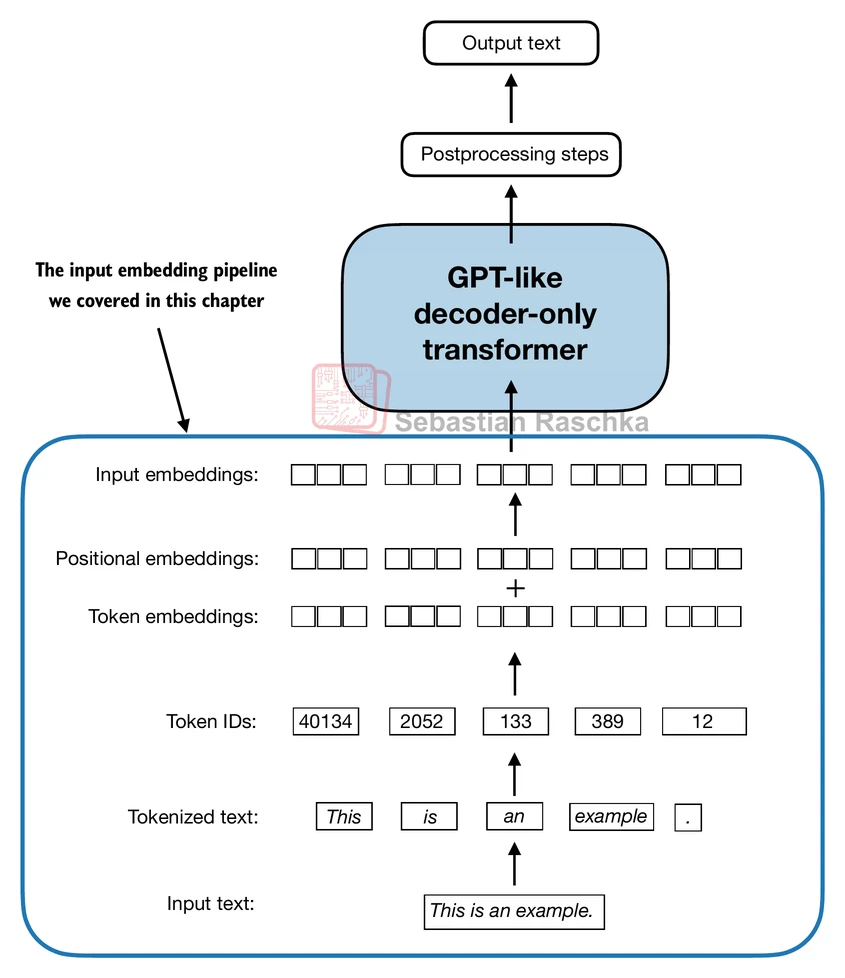

In [ ]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

In [ ]:
import os
import urllib.request


if not os.path.exists("the-verdict.txt"):
  url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt")
  file_path = "the-verdict.txt"
  urllib.request.urlretrieve(url, file_path)

In [ ]:
with open("the-verdict.txt","r", encoding="utf-8") as f:
  raw_text = f.read()

In [ ]:
raw_text

In [ ]:
len(raw_text)

In [ ]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

In [ ]:
result = re.split(r'([,.]|\s)', text)

print(result)

In [ ]:
# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

In [ ]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

In [ ]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

In [ ]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

In [ ]:
vocab = {token:integer for integer,token in enumerate(all_words)}
vocab

In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)

In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

In [ ]:
import importlib
import tiktoken


In [ ]:
tiktoken.__version__ # bite-pair encoding is a way to convert text into sub-word tokens

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
tokenizer.encode("Hello world, from Hrudai Roshan Mekala")

In [ ]:
tokenizer.decode([15496, 995, 11, 422, 367, 81, 463, 1872, 371, 3768, 272, 42859, 6081])

In [ ]:
tokenizer.n_vocab

In [ ]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

tokenizer.encode(text, allowed_special={"<|endoftext|>"})

In [ ]:
from enum import unique
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))
print(len(set(enc_text)))

In [ ]:
enc_sample = enc_text[50:]
print(enc_sample)

In [ ]:
import torch

In [ ]:
torch.__version__

In [ ]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    self.input_ids = []
    self.output_ids = []

    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
    assert len(token_ids) > max_length, "No of token Id's must atleast be equal to max_length+1"

    for i in range(0, len(token_ids) - max_length, stride):
        input_chunk = token_ids[i: i+max_length]
        output_chunk = token_ids[i+1: i+max_length+1]
        self.input_ids.append(torch.tensor(input_chunk))
        self.output_ids.append(torch.tensor(output_chunk))

  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self, idx):
    return self.input_ids[idx], self.output_ids[idx]

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128,shuffle=True,drop_last= True, num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers)

    return dataloader

In [ ]:
with open("the-verdict.txt","r", encoding="utf-8") as f:
  raw_text = f.read()

In [ ]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

In [ ]:
second_batch = next(data_iter)
print(second_batch)

In [ ]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
data_iter = iter(dataloader)
input, target = next(data_iter)
print("inputs :",  input)
print("targets :", target)

In [ ]:
vocab_size = tokenizer.n_vocab # GPT2 has the token size of 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)


In [ ]:
max_length = 4
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, target = next(data_iter)
print("Input token Id's:\n", inputs)
print("Input token Id's shape:\n", inputs.shape)

In [ ]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

In [ ]:
context_length = max_length #here it's 4, in line 37
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim) #output dimentions here are 256
print(pos_embedding_layer.weight)

In [ ]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings)

In [ ]:
input_embeddings = token_embeddings + pos_embeddings

# A Simple self-attention mechanism without trainable weights


In [ ]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [ ]:
inputs

In [ ]:
query = inputs[1]
attention_score_2 = torch.empty(inputs.shape[0])
for i in range(inputs.shape[0]):
  attention_score_2[i] = torch.dot(query, inputs[i])

attention_score_2

In [ ]:
attn_weights_2= torch.softmax(attention_score_2, dim=0)
print(attn_weights_2)

In [ ]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
  context_vec_2 += attn_weights_2[i] * x_i

print(context_vec_2)

In [ ]:
atten_scores = torch.zeros(6,6)

for i,x_i in enumerate(inputs):
  for j,x_j in enumerate(inputs):
    atten_scores[i,j] = torch.dot(x_i,x_j)

print(atten_scores)

In [ ]:
atten_weights = torch.softmax(atten_scores, dim=1)
print(atten_weights)

In [ ]:
context_vec_all = atten_weights @ inputs
print(context_vec_all)

In [ ]:
atten_scores_matrix = inputs @ inputs.T
atten_weights_matrix = torch.softmax(atten_scores_matrix, dim=1)
context_vec_all_matrix = atten_weights_matrix @ inputs
print(context_vec_all_matrix)

### Self-attention with trainable weights
In simple self-attention without trainable weights, the context vector need to have same dimension as inputs because we were taking weighted average. But in the self-attention with trainable weights, you can have any no of dimension for context vector.

In [ ]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in,d_out))
W_key = torch.nn.Parameter(torch.rand(d_in,d_out))
W_value = torch.nn.Parameter(torch.rand(d_in,d_out))

query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

keys = inputs @ W_key #because here query_2 is used everywhere and is constant, but key, value change
values = inputs @ W_value

key_2 = keys[1]
atten_scores_22 = torch.dot(query_2, key_2)
atten_scores_22

In [ ]:
atten_scores_2 = query_2 @ keys.T
atten_scores_2

In [ ]:
d_k = keys.shape[1]

atten_weights_2 = torch.softmax(atten_scores_2/d_k**0.5, dim =-1)
print(atten_scores_2)

In [ ]:
context_vec_2 = atten_weights_2 @ values
print(context_vec_2)

# Implementing a compact self attention class

In [ ]:
import torch.nn as nn

class SelfAttention_v1(nn.Module) :
  def __init__(self, d_in, d_out):
      super().__init__()
      self.W_query = nn.Parameter(torch.rand(d_in,d_out))
      self.W_key = nn.Parameter(torch.randn(d_in,d_out))
      self.W_value = nn.Parameter(torch.randn(d_in,d_out))

  def forward(self,x):
      queries = x @ self.W_query
      keys = x @ self.W_key
      values = x @ self.W_value

      attn_scores = queries @ keys.T
      attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim = -1)

      context_vec = attn_weights @ values
      return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in=3, d_out=2)
print(sa_v1(inputs))

In [ ]:
inputs

In [ ]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

# Hiding future words with causal attention

Applying causal attention mask

In [ ]:
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

In [ ]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length,context_length))
mask_simple


In [ ]:
masked_simple = attn_weights * mask_simple
masked_simple

In [ ]:
rows_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / rows_sums
masked_simple_norm

What we did till now, in the above lines : attention scores -> Normalised attention scores -> masked attention scores -> then Masked normalised attention scores.


Instead of that we can use the following way :
Attention scores -> Masked attention scores -> Masked Normalised attention scores(Masked attention weights)

In [ ]:
mask = torch.triu(torch.ones(context_length,context_length), diagonal=1)
mask

In [ ]:
mask.bool()

In [ ]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

In [ ]:
attn_weights = torch.softmax(masked/keys.shape[-1]**0.5, dim=-1)
attn_weights

Now masking additional attention weights with dropout

In [ ]:
torch.manual_seed(123)

attn_weights_dropout = torch.nn.Dropout(p=0.5)(attn_weights)
attn_weights_dropout

## Compact causal(future tokens are hidden) self attention class with dropout

In [ ]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch)

In [ ]:
class CausalAttention(nn.Module):

  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    b, num_tokens, d_in = x.shape

    queries = self.W_query(x)
    keys = self.W_key(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.transpose(-1,-2)
    attn_scores.masked_fill_(
        self.mask.bool()[:num_tokens, :num_tokens],-torch.inf)

    attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    context_vecs = atten_weights @ values
    return context_vecs

torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in,d_out,context_length,0.0)

context_vecs = ca(batch)
print(context_vecs)


## Masked multi head causal attention : stacking multiple single head attention layers


Stacking multiple single head attention layers

In [ ]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    self.heads = nn.ModuleList(
        [CausalAttention(d_in,d_out,context_length,dropout,qkv_bias=False) for _ in range(num_heads)]
    )

  def forward(self,x):
    return torch.cat([head(x) for head in self.heads], dim=-1)

torch.manual_seed(123)
context_length = batch.shape[1]
d_in,d_out=3,2
mha = MultiHeadAttentionWrapper(d_in,d_out,context_length,0.0,num_heads=2)
context_vecs = mha(batch)
print(context_vecs)

### Multi-head attention with weight splits

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # reshape into heads
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)

        # attention scores
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores = attn_scores.masked_fill(mask_bool.unsqueeze(0).unsqueeze(0), -torch.inf)

        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        # weighted sum
        context_vec = (attn_weights @ values).transpose(1, 2).contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec


## Coding an LLM architecture

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
from importlib.metadata import version

In [ ]:
import torch
import torch.nn as nn

### Normalizing activations with layer normalizations!

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
output = layer(batch_example)
print(output)

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased = False)
    norm_x = (x-mean)/torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

### Implementing a feedforward networks with GELU activations

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
# FeedForward : A small neural network module that we will be using it later in LLM's Transformer block

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )
  def forward(self,x):
    return self.layers(x)

In [ ]:
# connecting attention and linear layers into a TRANSFORMER BLOCK

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
      super().__init__()
      self.att = MultiHeadAttention(
          d_in = cfg["emb_dim"],
          d_out = cfg["emb_dim"],
          context_length = cfg["context_length"],
          dropout= cfg["drop_rate"],
          num_heads = cfg["n_heads"],
          qkv_bias = cfg["qkv_bias"])
      self.ff = FeedForward(cfg)
      self.Norm1 = LayerNorm(cfg["emb_dim"])
      self.Norm2 = LayerNorm(cfg["emb_dim"])
      self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
      # shorcut connection for attention block
      shortcut = x
      x = self.Norm1(x)
      x = self.att(x)
      x = self.drop_shortcut(x)
      x = shortcut + x
      # shortcut connection for FeedForward block
      shortcut = x
      x = self.Norm2(x)
      x = self.ff(x)
      x = self.drop_shortcut(x)
      x = shortcut + x
      return x

In [ ]:
# Now we will assemble all the above blocks to create a GPT model

class GPTModel(nn.Module):

  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias= False)


  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
total_parameters = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters : {total_parameters:,}")

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:]
    probs = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probs, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=-1)
  return idx

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

### Pre-training of unlabled data

Making GPT to generate text

In [ ]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [ ]:
import torch
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();


In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    return tokenizer.decode(token_ids.squeeze(0).tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


In [ ]:
# Generating the text generation loss - Cross-entropy

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)

In [ ]:
probas

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token Id's : \n", token_ids)

In [ ]:
print(f"Target batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Predicted batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)} ")

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("text 2:", target_probas_2)

In [ ]:
print("logits shape:", logits.shape)
print("targets shape:", targets.shape)

In [ ]:
print(f"Flatenned logits: {logits.flatten(0,1).shape}")
print(f"Flatenned targets:{targets.flatten().shape}")

In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("loss :", loss)
perplexity = torch.exp(loss)
print("perplexity:", perplexity)

In [ ]:
file_path

In [ ]:
import os

file_path = "the-verdict.txt"

# Since the file already exists, just read it
if os.path.exists(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()
    print("File loaded successfully.")
else:
    raise FileNotFoundError(f"The file '{file_path}' does not exist. Please check the path.")

In [ ]:
print(text_data[:99])

In [ ]:
print(text_data[-99:])

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

In [ ]:
create_dataloader_v1

In [ ]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last= True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last= False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

In [ ]:
len(train_loader)

In [ ]:
train_tokens= 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()
val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
model.to(device);

In [ ]:
#calculating training and validation set losses

def cal_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) ==0:
        return float("NaN")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
      # Reduce the number of batches to match the total number of batches in the data loader
      # if num_batches exceeds the number of batches in the data
        num_batches = min(num_batches, len(data_loader))

    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
  train_loss = cal_loss_loader(train_loader, model, device)
  val_loss = cal_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

### TRAINING AN LLM

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = cal_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = cal_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [113]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

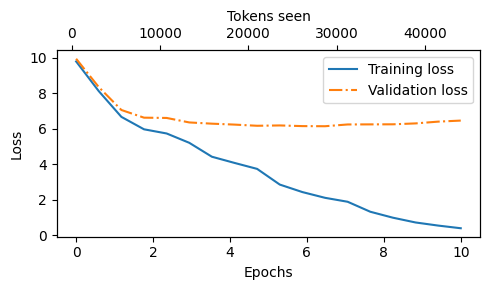

In [114]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Decoding strategies to control randomness

In [115]:
model.to(device)
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model, idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25, context_size=GPT_CONFIG_124M['context_length']
)
print("output text :\n",token_ids_to_text(token_ids, tokenizer))

output text :
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


In [122]:
# New text generation function with multinomial, temperature and top_n sampling

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits, top_indices = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits<min_val, torch.tensor(float("-inf")).to(logits.device), other=logits)

        if temperature >0.0:
            logits = logits / temperature
            logits = logits - logits.max(dim=-1, keepdim=True).values
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next),dim=1)

    return idx

In [119]:
torch.manual_seed(123)
token_ids = generate(model = model, idx= text_to_token_ids("Every effort moves you", tokenizer).to(device),
                     max_new_tokens=15,context_size=GPT_CONFIG_124M["context_length"],top_k=25,temperature=1.4)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


In [121]:
torch.save(model.state_dict(),"model.pth")

In [123]:
model = GPTModel(GPT_CONFIG_124M)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
else:
    torch.device("cpu")

print("Device:", device)
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();


Device: cpu


In [124]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [125]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# Loading PreTrained weights from OpenAI

In [126]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [128]:
from gpt_download import download_and_load_gpt2

In [129]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 173kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 912kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 220kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:27<00:00, 5.72MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 5.49MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 617kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 702kiB/s]


In [130]:
print("settings:", settings)

settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [131]:
print("parameter dictionary keys:", params.keys())

parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [133]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [134]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG =  GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt=GPTModel(NEW_CONFIG)
gpt.eval();

In [135]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [142]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        #  Updated capitalization for your model
        gpt.trf_blocks[b].Norm1.scale = assign(
            gpt.trf_blocks[b].Norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].Norm1.shift = assign(
            gpt.trf_blocks[b].Norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].Norm2.scale = assign(
            gpt.trf_blocks[b].Norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].Norm2.shift = assign(
            gpt.trf_blocks[b].Norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

load_weights_into_gpt(gpt, params)
gpt.to(device);

In [144]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=100,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?

As much as our intuition makes us try a lot, that intuitive part goes unchanging and changes over time. A new aspect becomes very attractive and makes up for our limitations. It helps explain our goals we'd like us to hold more strongly after their success has already led us to success.<|endoftext|>Pretend that all you learned from that college prep class that night is the


# Fine tuning for classification